In [3]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

try:
    tf.enable_eager_execution()
except:
    pass

tf.executing_eagerly()
tf.random.set_seed(32)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Clustering analysis on isotropic Gaussian clusters

## Adversarial Autoencoder: Basic Architecture

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 30
}

In [5]:
model = AAE1(**parameters)

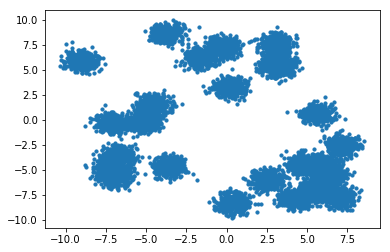

In [6]:
# Create dataset

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

NUM_CLUSTERS = 25

features, target = make_blobs(n_samples = 10000,
                              n_features = 2000,
                              centers = NUM_CLUSTERS,
                              cluster_std = 0.5,
                              shuffle = True,
                              random_state = 32)

model.data = features
model.original_dim = model.data.shape[1]
model.labels = target
model.gene_list = target

plt.scatter(features[:,0], features[:,1], s=10)
plt.show()

In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,30,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2000)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          400200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [12]:
# Export model graphs

log_dir = '../results/AAE1/GAUSSIAN-CLUSTERING/' + str(NUM_CLUSTERS)
os.makedirs(log_dir + '/graphs', exist_ok=True)
model.export_graph(log_dir + '/graphs')

Model graphs saved.



### Train the model

In [13]:
# Create the input dataset

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)

train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

In [14]:
# Training...

log_dir = '../results/AAE1/GAUSSIAN-CLUSTERING/' + str(NUM_CLUSTERS) + '/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = False

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, enable_function=True, graph=GRAPH, log_dir=log_dir)

Epoch 30/30, rec. loss: 0.551562, dis. loss: 0.200125
Training completed.
All networks exported in h5 format.


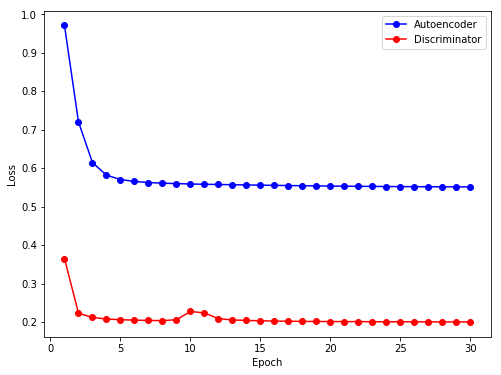

In [15]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

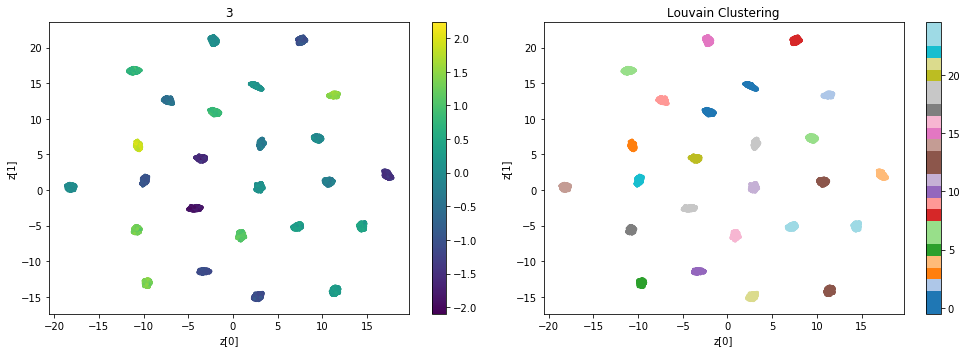

In [16]:
GENE_LIST = [3]
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [17]:
labels_true = model.labels

In [18]:
res = [0.5, 0.6, 0.7]
n_nbs = [6, 8, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 9/9 [06:38<00:00, 45.68s/it]


In [19]:
out

{'res': array([0.5, 0.6, 0.7, 0.5, 0.6, 0.7, 0.5, 0.6, 0.7]),
 'n_nbs': array([ 6,  6,  6,  8,  8,  8, 10, 10, 10]),
 'n_pcs': array([50, 50, 50, 50, 50, 50, 50, 50, 50]),
 'ARI': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'AMI': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'CA': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [20]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

0
0
0


In [21]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 6


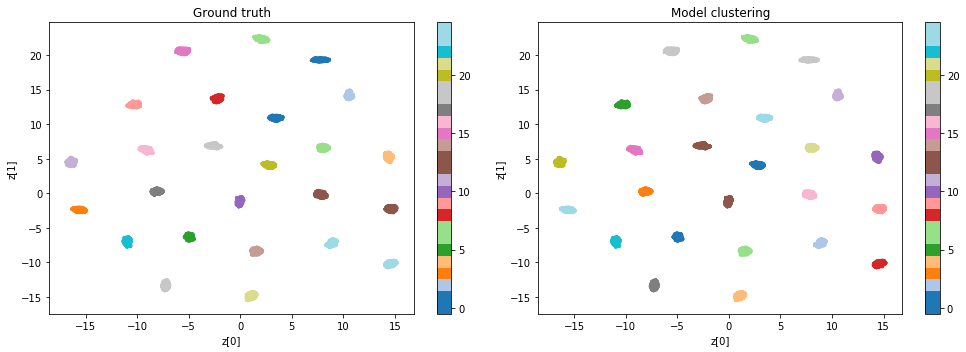

Measures of clusters similarity:

adjusted random index = 1.0
adjusted mutual information = 1.0
clustering accuracy = 1.0


In [22]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [ ]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [ ]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

## Variational Autoencoder

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

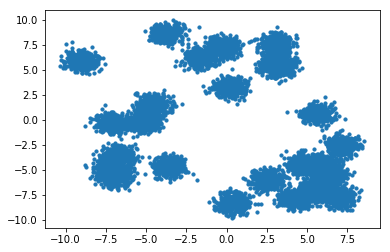

In [6]:
# Create dataset

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

NUM_CLUSTERS = 25

features, target = make_blobs(n_samples = 10000,
                              n_features = 2000,
                              centers = NUM_CLUSTERS,
                              cluster_std = 0.5,
                              shuffle = True,
                              random_state = 32)

model.data = features
model.original_dim = model.data.shape[1]
model.labels = target
model.gene_list = target

plt.scatter(features[:,0], features[:,1], s=10)
plt.show()

In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
else:
    model.build_model()

W1212 17:40:05.737975 140598585108288 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2000)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          400200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/GAUSSIAN-CLUSTERING/' + str(NUM_CLUSTERS)
os.makedirs(log_dir + '/graphs', exist_ok=True)
model.export_graph(log_dir + '/graphs')

Model graphs saved.



### Train the model

In [12]:
import time
start = time.time()

In [13]:
# Training...

log_dir = '../results/VAE/GAUSSIAN-CLUSTERING/' + str(NUM_CLUSTERS) + '/'
os.makedirs(log_dir, exist_ok=True)

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Internal',
                             num_workers=24)

Start model training...
Train on 8000 samples, validate on 2000 samples
Epoch 1/500
8000/8000 [==============================] - 7s 874us/sample - loss: 2489.7139 - val_loss: 2481.1760
Epoch 2/500
8000/8000 [==============================] - 0s 44us/sample - loss: 2432.8503 - val_loss: 2457.7299
Epoch 3/500
8000/8000 [==============================] - 0s 46us/sample - loss: 2381.9348 - val_loss: 2431.2157
Epoch 4/500
8000/8000 [==============================] - 0s 45us/sample - loss: 2334.6154 - val_loss: 2401.8928
Epoch 5/500
8000/8000 [==============================] - 0s 44us/sample - loss: 2290.7881 - val_loss: 2372.2415
Epoch 6/500
8000/8000 [==============================] - 0s 44us/sample - loss: 2250.7977 - val_loss: 2340.3068
Epoch 7/500
8000/8000 [==============================] - 0s 39us/sample - loss: 2213.4703 - val_loss: 2309.6458
Epoch 8/500
8000/8000 [==============================] - 0s 41us/sample - loss: 2179.9502 - val_loss: 2277.4866
Epoch 9/500
8000/8000 [========

In [14]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:02:29.53


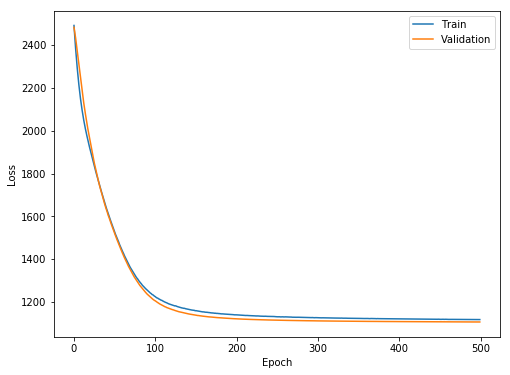

In [15]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

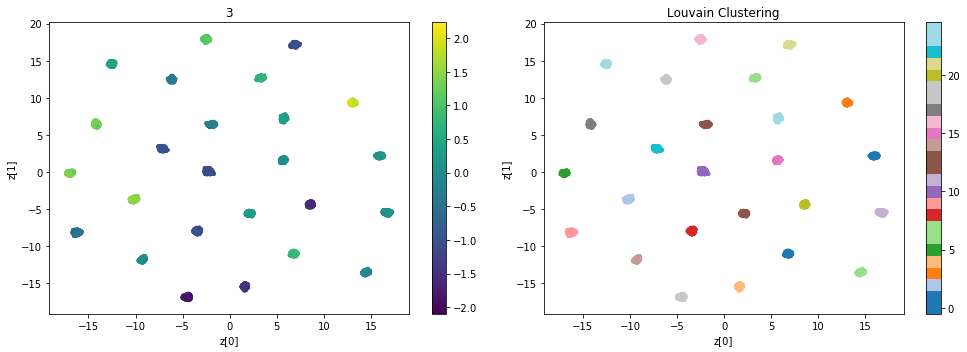

In [16]:
gene_list = [3]
model.plot_umap(gene_selected=gene_list, louvain=True)

In [17]:
labels_true = model.labels

In [18]:
res = [0.5, 0.6, 0.7]
n_nbs = [6, 8, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 9/9 [04:40<00:00, 31.94s/it]


In [19]:
out

{'res': array([0.5, 0.6, 0.7, 0.5, 0.6, 0.7, 0.5, 0.6, 0.7]),
 'n_nbs': array([ 6,  6,  6,  8,  8,  8, 10, 10, 10]),
 'n_pcs': array([50, 50, 50, 50, 50, 50, 50, 50, 50]),
 'ARI': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'AMI': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'CA': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [20]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

0
0
0


In [21]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 6


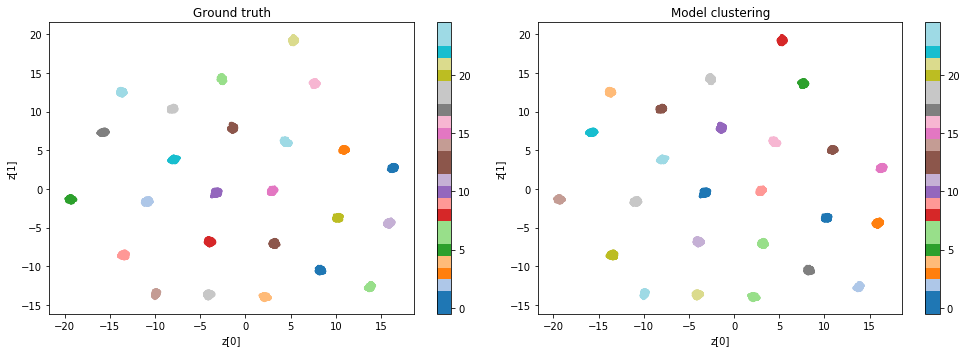

Measures of clusters similarity:

adjusted random index = 1.0
adjusted mutual information = 1.0
clustering accuracy = 1.0


In [22]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [ ]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [ ]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

# Clustering analysis on CLUSTER1-8k-SPLATTER data


## Adversarial Autoencoder: Basic Architecture

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 200
}

In [5]:
model = AAE1(**parameters)

In [19]:
# Create dataset

data_path = '../data/proc/cluster1-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [20]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [21]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [22]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [23]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6998)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1399800     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [24]:
# Export model graphs

log_dir = '../results/AAE1/CLUSTER1-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/CLUSTER1-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/AAE1/CLUSTER1-8k-SPLATTER/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/CLUSTER1-8k-SPLATTER/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/CLUSTER1-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [25]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/cluster1-8k-splatter.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 52/200, rec. loss: 0.971277, dis. loss: 0.261995


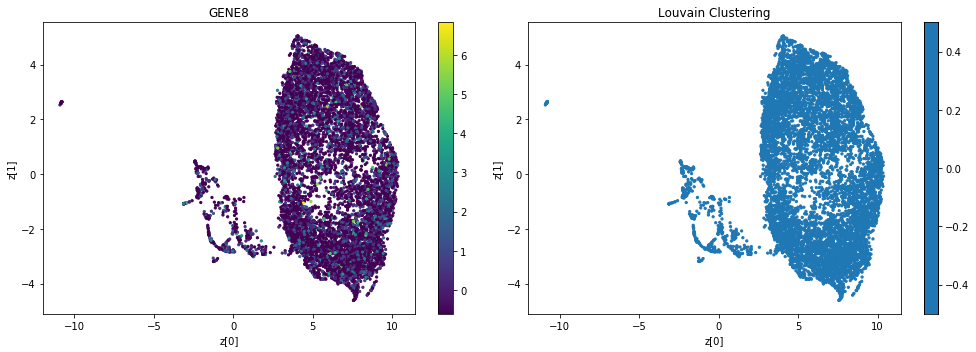

In [ ]:
# Training...

log_dir = '../results/AAE1/CLUSTER1-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'GENE8'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['GENE8']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
labels_true = model.labels

In [16]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [40:12<00:00, 13.71s/it]


In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [47]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.adata.X)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.685
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES = 0.7
N_NBS = 7
N_PCS = 40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/cluster1-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
else:
    model.build_model()

W1210 12:33:54.056004 140220765738816 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6998)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1399800     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/CLUSTER1-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/CLUSTER1-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/VAE/CLUSTER1-8k-SPLATTER/graphs/decoder.png)

[AUTOENCODER](../results/VAE/CLUSTER1-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [12]:
import time
start = time.time()

In [13]:
# Training...

log_dir = '../results/VAE/CLUSTER1-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/cluster1-8k-splatter.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 6 steps, validate for 1 steps
Epoch 1/500
6/6 [==============================] - 3s 463ms/step - loss: 8669.7054 - val_loss: 8704.0762
Epoch 2/500
6/6 [==============================] - 0s 68ms/step - loss: 8519.4686 - val_loss: 8658.0264
Epoch 3/500
6/6 [==============================] - 0s 74ms/step - loss: 8384.0959 - val_loss: 8616.8789
Epoch 4/500
6/6 [==============================] - 0s 69ms/step - loss: 8266.5027 - val_loss: 8575.5303
Epoch 5/500
6/6 [==============================] - 0s 73ms/step - loss: 8144.2977 - val_loss: 8539.0537
Epoch 6/500
6/6 [==============================] - 0s 68ms/step - loss: 8031.6784 - val_loss: 8501.3389
Epoch 7/500
6/6 [==============================] - 0s 68ms/step - loss: 7934.2157 - val_loss: 8468.2500
Epoch 8/500
6/6 [==============================] - 0s 68ms/step - loss: 7838.2824 - val_loss: 8437.6699
Epoch 9/500
6/6 [==============================] - 0s 66ms/step - loss: 7757.8209 - val_loss: 8410.1396

In [14]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:04:31.52


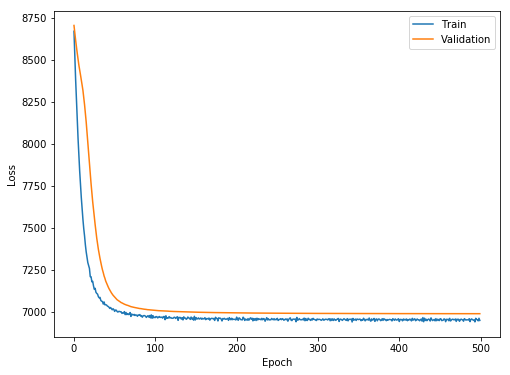

In [15]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

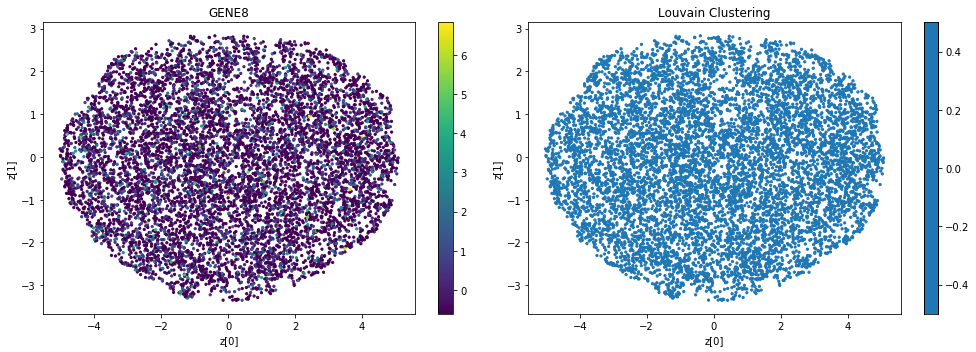

In [18]:
gene_list = ['GENE8']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [19]:
labels_true = model.labels

In [24]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 78/78 [29:47<00:00, 23.91s/it]


In [25]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

0
0
0


In [26]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.1 5


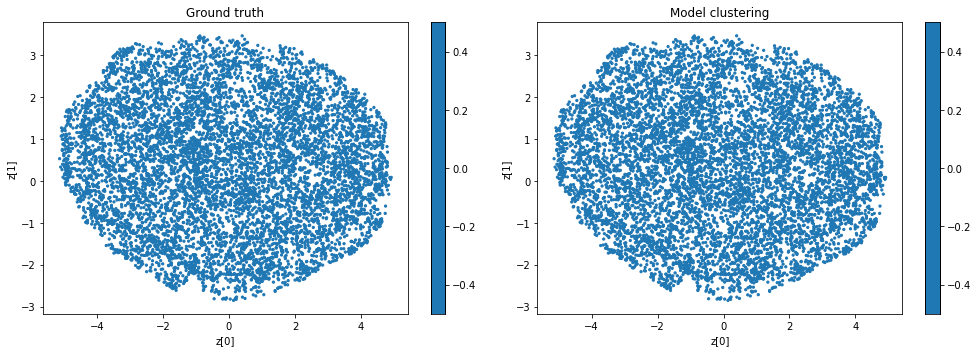

Measures of clusters similarity:

adjusted random index = 1.0
adjusted mutual information = 1.0
clustering accuracy = 1.0


In [27]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

# Clustering analysis on CLUSTER3-8k-SPLATTER data

## Adversarial Autoencoder: Basic Architecture

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/cluster3-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6865)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1373200     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/CLUSTER3-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/CLUSTER3-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/AAE1/CLUSTER3-8k-SPLATTER/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/CLUSTER3-8k-SPLATTER/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/CLUSTER3-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/cluster3-8k-splatter.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.976817, dis. loss: 0.215830


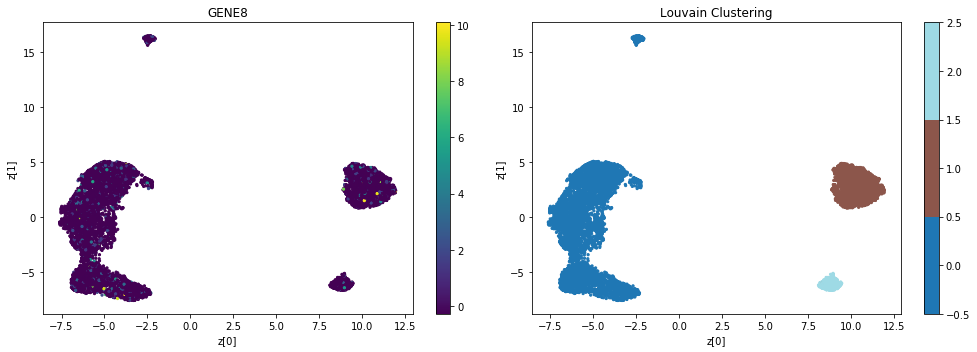

Training completed.
All networks exported in h5 format.


In [18]:
# Training...

log_dir = '../results/AAE1/CLUSTER3-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'GENE8'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

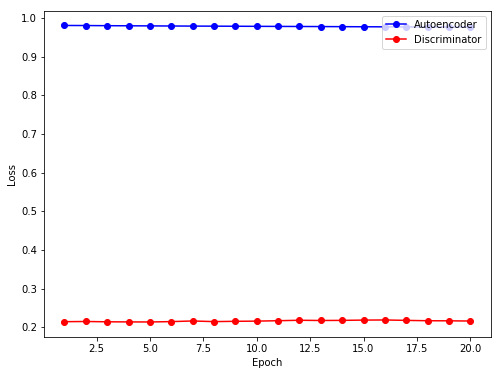

In [19]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['GENE8']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
labels_true = model.labels

In [ ]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

## Variational Autoencoder

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/cluster3-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
else:
    model.build_model()

W1210 12:33:54.056004 140220765738816 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6998)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1399800     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/CLUSTER3-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/CLUSTER3-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/VAE/CLUSTER3-8k-SPLATTER/graphs/decoder.png)

[AUTOENCODER](../results/VAE/CLUSTER3-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [12]:
import time
start = time.time()

In [13]:
# Training...

log_dir = '../results/VAE/CLUSTER3-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/cluster3-8k-splatter.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 6 steps, validate for 1 steps
Epoch 1/500
6/6 [==============================] - 3s 463ms/step - loss: 8669.7054 - val_loss: 8704.0762
Epoch 2/500
6/6 [==============================] - 0s 68ms/step - loss: 8519.4686 - val_loss: 8658.0264
Epoch 3/500
6/6 [==============================] - 0s 74ms/step - loss: 8384.0959 - val_loss: 8616.8789
Epoch 4/500
6/6 [==============================] - 0s 69ms/step - loss: 8266.5027 - val_loss: 8575.5303
Epoch 5/500
6/6 [==============================] - 0s 73ms/step - loss: 8144.2977 - val_loss: 8539.0537
Epoch 6/500
6/6 [==============================] - 0s 68ms/step - loss: 8031.6784 - val_loss: 8501.3389
Epoch 7/500
6/6 [==============================] - 0s 68ms/step - loss: 7934.2157 - val_loss: 8468.2500
Epoch 8/500
6/6 [==============================] - 0s 68ms/step - loss: 7838.2824 - val_loss: 8437.6699
Epoch 9/500
6/6 [==============================] - 0s 66ms/step - loss: 7757.8209 - val_loss: 8410.1396

In [14]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:04:31.52


In [ ]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
gene_list = ['GENE8']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [19]:
labels_true = model.labels

In [24]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 78/78 [29:47<00:00, 23.91s/it]


In [25]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

0
0
0


In [26]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.1 5


In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

# Clustering analysis on CLUSTER5-8k-SPLATTER data

## Adversarial Autoencoder: Basic Architecture

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/cluster5-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6995)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1399200     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/CLUSTER5-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/CLUSTER5-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/AAE1/CLUSTER5-8k-SPLATTER/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/CLUSTER5-8k-SPLATTER/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/CLUSTER5-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/cluster5-8k-splatter.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.936908, dis. loss: 0.225826


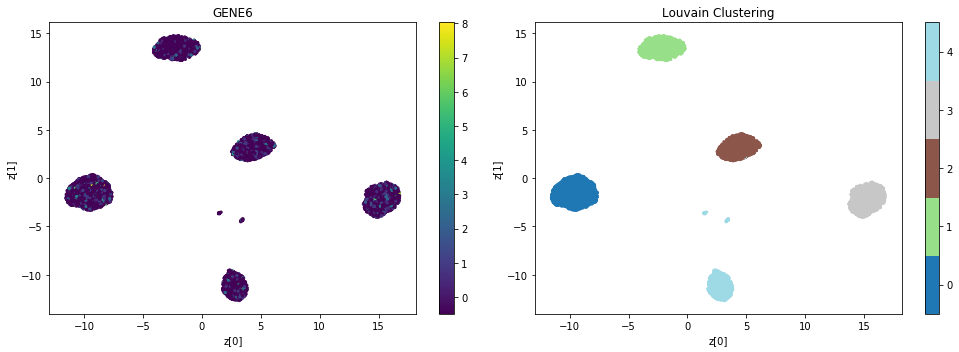

Training completed.
All networks exported in h5 format.


In [18]:
# Training...

log_dir = '../results/AAE1/CLUSTER5-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'GENE6'  # used only for training visualization

tf.set_random_seed(32)

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

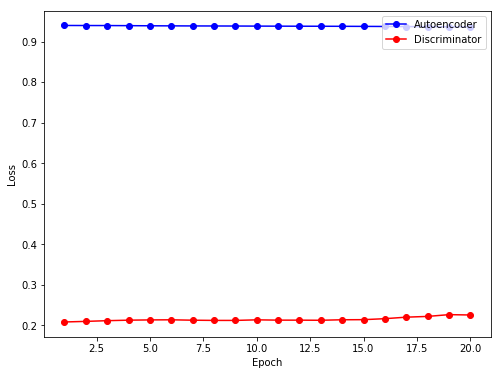

In [19]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

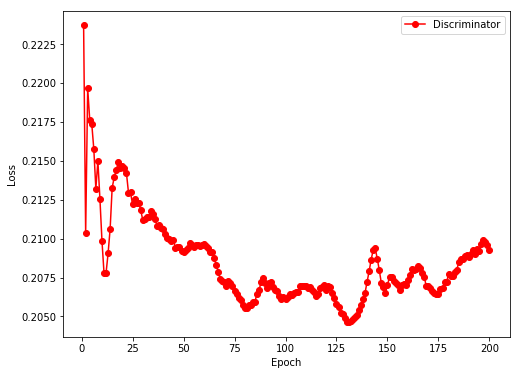

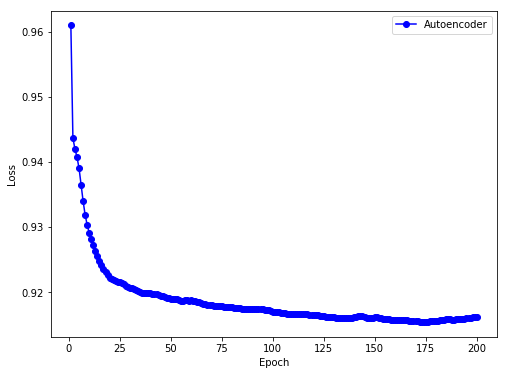

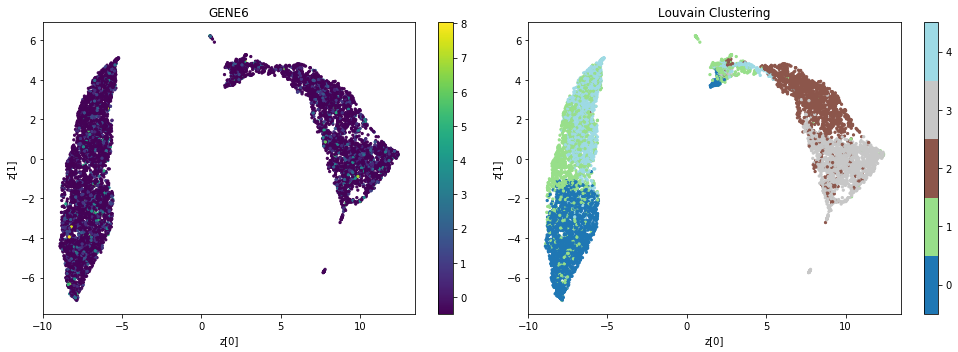

In [15]:
GENE_LIST = ['GENE6']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [16]:
labels_true = model.labels

In [ ]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

## Variational Autoencoder

### Build the model

In [21]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [22]:
model = VAE(**parameters)

In [23]:
# Import dataset

data_path = '../data/proc/cluster5-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [24]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [25]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [26]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
else:
    model.build_model()

W1211 16:45:04.517873 139880873965376 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [27]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 6995)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1399200     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [28]:
# Export model graphs

log_dir = '../results/VAE/CLUSTER5-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/decoder.png)

[AUTOENCODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [29]:
import time
start = time.time()

In [31]:
# Training...

log_dir = '../results/VAE/CLUSTER5-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Dataset',
                             num_workers=24)

Start model training...
Train for 6 steps, validate for 1 steps
Epoch 1/500
6/6 [==============================] - 4s 713ms/step - loss: 8705.4378 - val_loss: 8694.3994
Epoch 2/500
6/6 [==============================] - 0s 69ms/step - loss: 8567.8110 - val_loss: 8639.4668
Epoch 3/500
6/6 [==============================] - 0s 64ms/step - loss: 8436.3573 - val_loss: 8583.5146
Epoch 4/500
6/6 [==============================] - 0s 63ms/step - loss: 8291.8883 - val_loss: 8528.9346
Epoch 5/500
6/6 [==============================] - 0s 71ms/step - loss: 8185.2253 - val_loss: 8464.9141
Epoch 6/500
6/6 [==============================] - 0s 65ms/step - loss: 8075.7552 - val_loss: 8388.1182
Epoch 7/500
6/6 [==============================] - 0s 62ms/step - loss: 7956.8309 - val_loss: 8294.8223
Epoch 8/500
6/6 [==============================] - 0s 63ms/step - loss: 7866.1590 - val_loss: 8185.0151
Epoch 9/500
6/6 [==============================] - 0s 64ms/step - loss: 7766.2870 - val_loss: 8047.3008

In [32]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:03:42.13


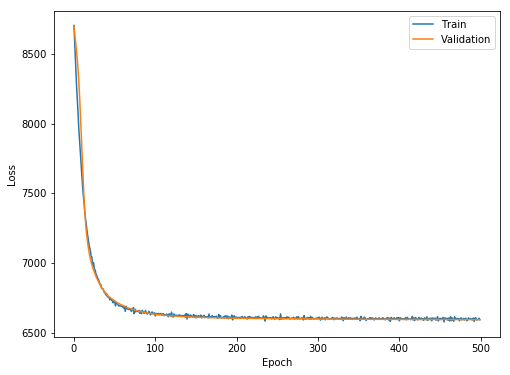

In [33]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

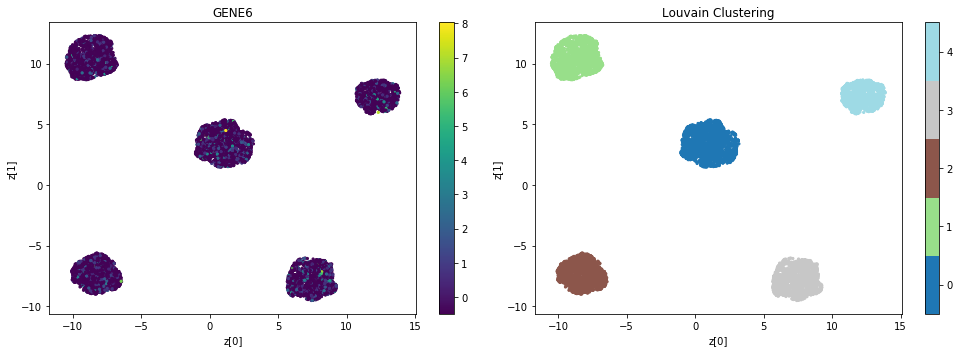

In [35]:
gene_list = ['GENE6']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [ ]:
labels_true = model.labels

In [ ]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

# Clustering analysis on CLUSTER12-8k-SPLATTER data

## Adversarial Autoencoder: Basic Architecture

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/cluster12-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 7860)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1572200     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/CLUSTER12-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/CLUSTER12-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/AAE1/CLUSTER12-8k-SPLATTER/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/CLUSTER12-8k-SPLATTER/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/CLUSTER12-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/cluster12-8k-splatter.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.789862, dis. loss: 0.202859


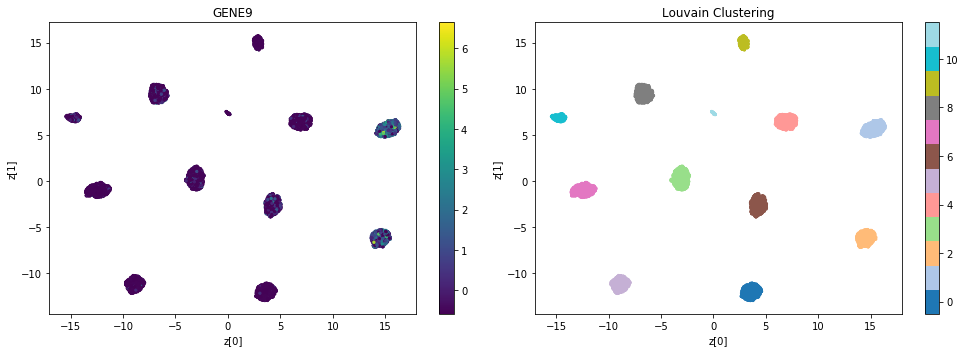

Training completed.
All networks exported in h5 format.


In [13]:
# Training...

log_dir = '../results/AAE1/CLUSTER12-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'GENE9'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

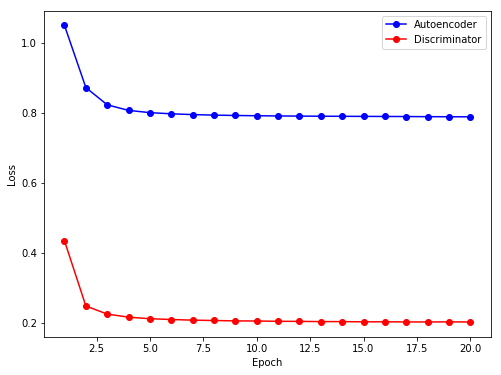

In [14]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['GENE9']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
labels_true = model.labels

In [16]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [40:12<00:00, 13.71s/it]


In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

## Variational Autoencoder

### Build the model

In [15]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [16]:
model = VAE(**parameters)

In [17]:
# Import dataset

data_path = '../data/proc/cluster12-8k-splatter.h5ad'

model.load_data(data_path)

Dataset imported.


In [18]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [19]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [20]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
else:
    model.build_model()

W1211 18:14:00.708026 140246246930240 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [21]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 7860)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          1572200     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [22]:
# Export model graphs

log_dir = '../results/VAE/CLUSTER12-8k-SPLATTER/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph(log_dir + 'graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/encoder.png)

[DECODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/decoder.png)

[AUTOENCODER](../results/VAE/CLUSTER5-8k-SPLATTER/graphs/autoencoder.png)

### Train the model

In [23]:
import time
start = time.time()

In [25]:
# Training...

log_dir = '../results/VAE/CLUSTER12-8k-SPLATTER/'
os.makedirs(log_dir, exist_ok=True)

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Internal',
                             num_workers=24)

Start model training...
Train on 6704 samples, validate on 1677 samples
Epoch 1/500
6704/6704 [==============================] - 3s 462us/sample - loss: 9768.7313 - val_loss: 9733.5938
Epoch 2/500
6704/6704 [==============================] - 1s 80us/sample - loss: 9579.4944 - val_loss: 9623.4473
Epoch 3/500
6704/6704 [==============================] - 1s 83us/sample - loss: 9400.3052 - val_loss: 9484.3494
Epoch 4/500
6704/6704 [==============================] - 1s 84us/sample - loss: 9229.2010 - val_loss: 9319.3777
Epoch 5/500
6704/6704 [==============================] - 1s 86us/sample - loss: 9066.0215 - val_loss: 9142.0580
Epoch 6/500
6704/6704 [==============================] - 1s 83us/sample - loss: 8911.0065 - val_loss: 8963.8259
Epoch 7/500
6704/6704 [==============================] - 1s 80us/sample - loss: 8766.8817 - val_loss: 8801.9035
Epoch 8/500
6704/6704 [==============================] - 1s 80us/sample - loss: 8628.9704 - val_loss: 8646.8809
Epoch 9/500
6704/6704 [========

In [26]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:04:37.43


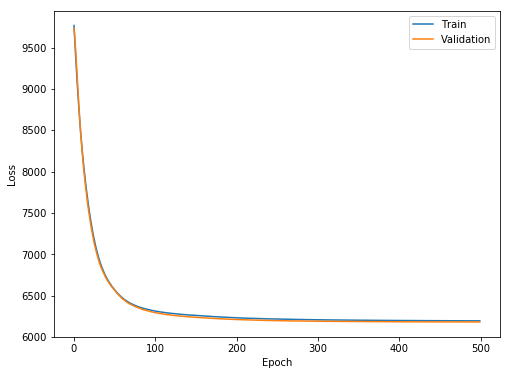

In [27]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

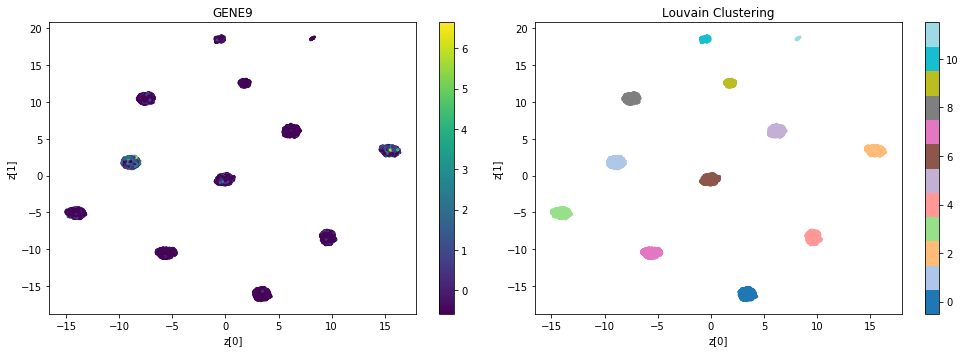

In [28]:
gene_list = ['GENE9']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [ ]:
labels_true = model.labels

In [ ]:
res = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_nbs = [5, 6, 7, 8, 9, 10]
n_pcs = [50]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

# Clustering analysis on 10k PBMC data

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'layers_dis_dim': [1000, 500, 400, 300, 200],
#     'batch_size': 1000,
#     'epochs': 20
# }

parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

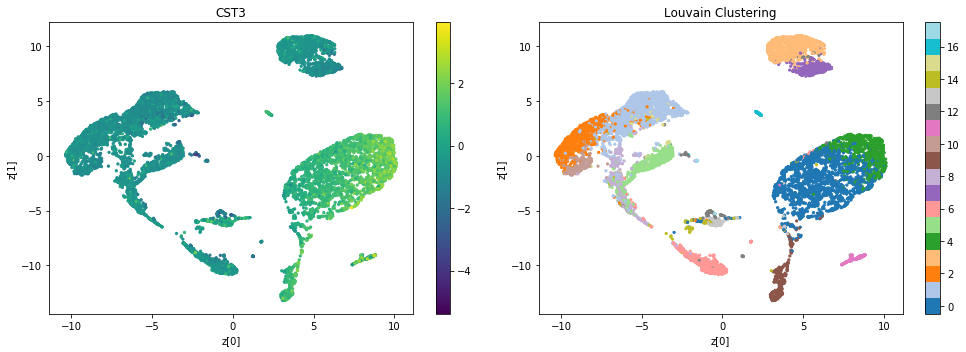

In [14]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [40:12<00:00, 13.71s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

121
132
121


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


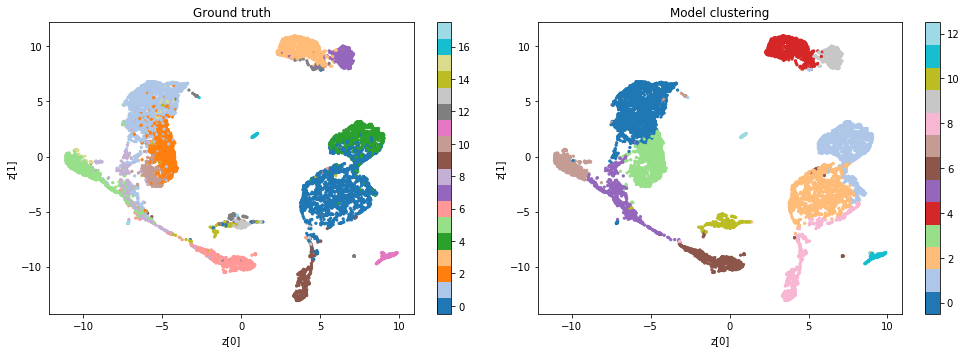

Measures of clusters similarity:

adjusted random index = 0.6382175390878992
adjusted mutual information = 0.7455126841400547
clustering accuracy = 0.7719567177637511


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [47]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.adata.X)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.685
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES = 0.7
N_NBS = 7
N_PCS = 40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'batch_size': 1000,
#     'epochs': 5000
# }
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
import time
start = time.time()

In [12]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 8 steps, validate for 2 steps
Epoch 1/500
8/8 [==============================] - 6s 735ms/step - loss: 3217.6324 - val_loss: 3069.5796
Epoch 2/500
8/8 [==============================] - 1s 138ms/step - loss: 3015.7090 - val_loss: 2941.9417
Epoch 3/500
8/8 [==============================] - 1s 145ms/step - loss: 2838.5810 - val_loss: 2855.4491
Epoch 4/500
8/8 [==============================] - 1s 136ms/step - loss: 2709.1179 - val_loss: 2786.0481
Epoch 5/500
8/8 [==============================] - 1s 130ms/step - loss: 2590.7911 - val_loss: 2727.3512
Epoch 6/500
8/8 [==============================] - 1s 128ms/step - loss: 2501.9367 - val_loss: 2675.9681
Epoch 7/500
8/8 [==============================] - 1s 132ms/step - loss: 2433.5291 - val_loss: 2628.9075
Epoch 8/500
8/8 [==============================] - 1s 131ms/step - loss: 2370.1415 - val_loss: 2587.1367
Epoch 9/500
8/8 [==============================] - 1s 133ms/step - loss: 2321.5205 - val_loss: 2

In [13]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:09:26.67


In [ ]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [17]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [43:36<00:00, 14.87s/it]


In [18]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

55
127
127


In [19]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.8 16


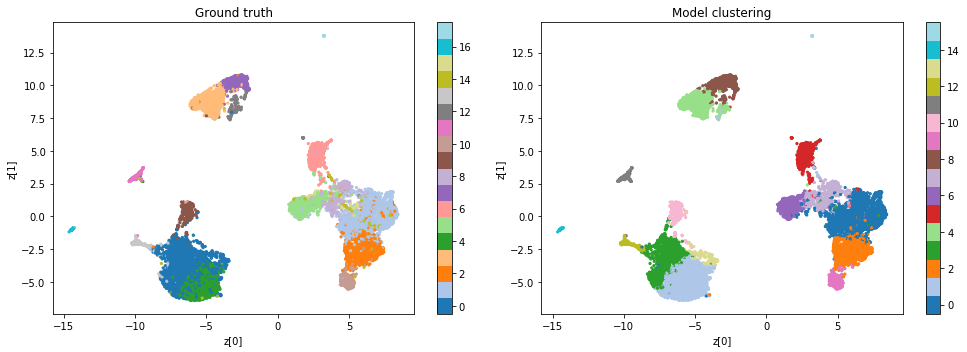

Measures of clusters similarity:

adjusted random index = 0.6583853132655431
adjusted mutual information = 0.7842456318302405
clustering accuracy = 0.7972046889089269


In [20]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

# Clustering analysis on 8k PBMC data¶

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1330)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          266200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC8k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC8k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC8k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC8k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC8k/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc8k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.908094, dis. loss: 0.224129


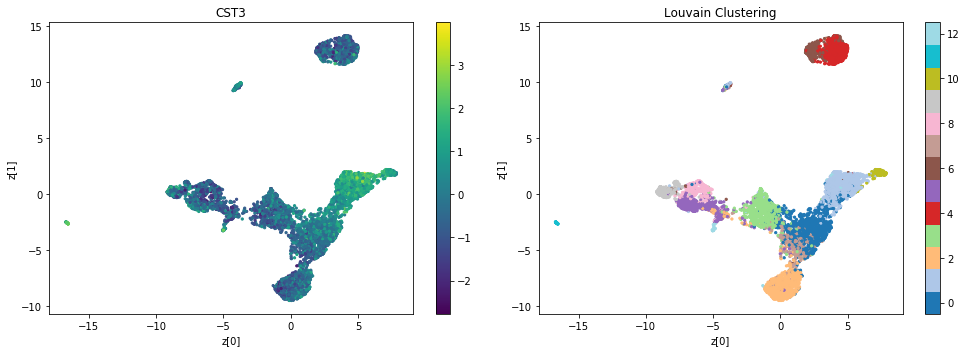

Training completed.
All networks exported in h5 format.


In [13]:
# Training...

log_dir = '../results/AAE1/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC8k/

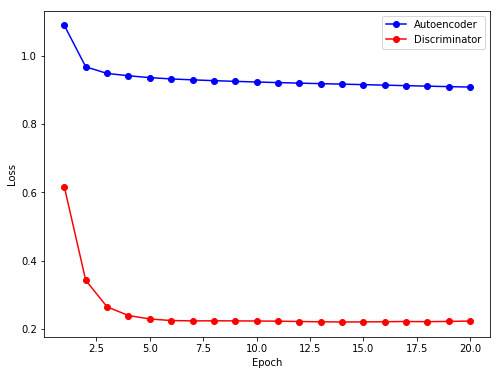

In [14]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

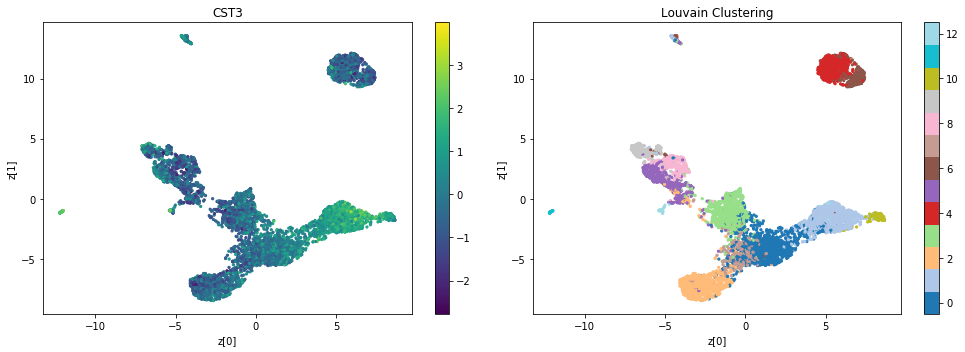

In [15]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [16]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [17]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [50:12<00:00, 17.12s/it]


In [18]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

84
119
106


In [19]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.85 14


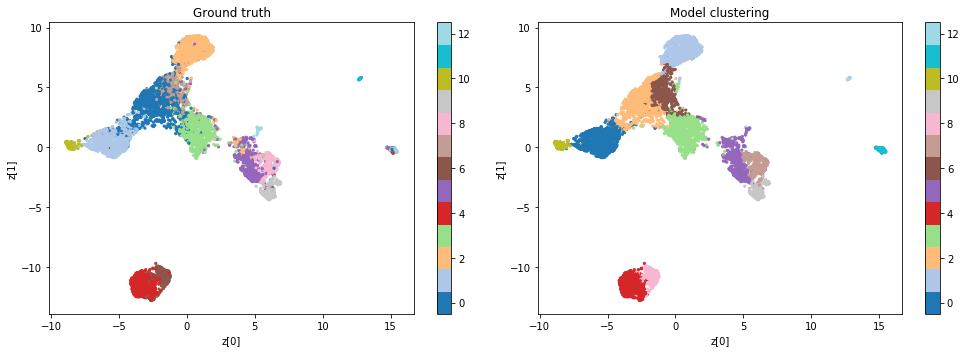

Measures of clusters similarity:

adjusted random index = 0.7250001098051719
adjusted mutual information = 0.7619221030032381
clustering accuracy = 0.8421404682274247


In [20]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC8k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC8k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC8k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC8k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC8k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc8k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1330)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          266200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC8k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC8k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC8k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC8k/graphs/autoencoder.png)

### Train the model

In [12]:
# Training...

log_dir = '../results/VAE/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc8k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Dataset',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 5 steps, validate for 1 steps
Epoch 1/500
5/5 [==============================] - 6s 1s/step - loss: 1674.3296 - val_loss: 1674.1995
Epoch 2/500
5/5 [==============================] - 0s 89ms/step - loss: 1645.3498 - val_loss: 1662.8770
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: 1624.7534 - val_loss: 1654.3693
Epoch 4/500
5/5 [==============================] - 0s 100ms/step - loss: 1595.5724 - val_loss: 1646.8469
Epoch 5/500
5/5 [==============================] - 1s 110ms/step - loss: 1578.3660 - val_loss: 1639.6288
Epoch 6/500
5/5 [==============================] - 1s 117ms/step - loss: 1565.2128 - val_loss: 1632.1558
Epoch 7/500
5/5 [==============================] - 0s 92ms/step - loss: 1545.1048 - val_loss: 1625.2648
Epoch 8/500
5/5 [==============================] - 0s 98ms/step - loss: 1521.0777 - val_loss: 1617.5618
Epoch 9/500
5/5 [==============================] - 1s 104ms/step - loss: 1518.6210 - val_loss: 1611.420

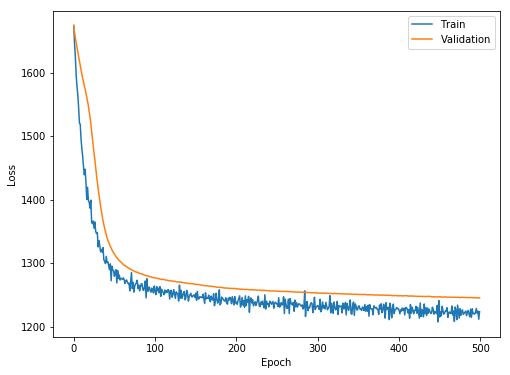

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

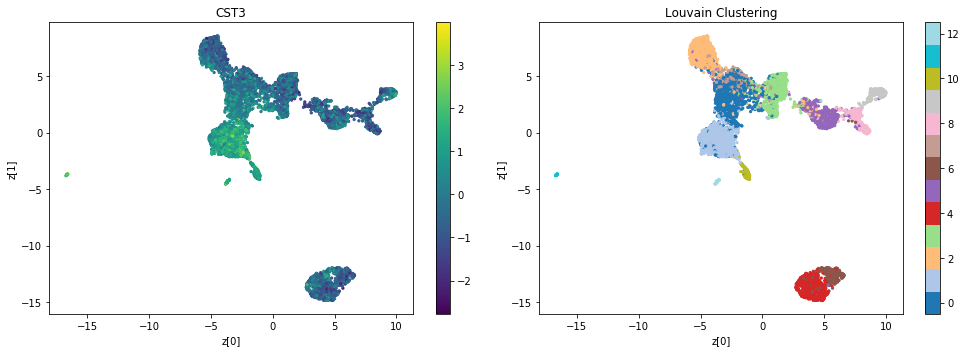

In [14]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [1:02:03<00:00, 21.16s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

93
125
93


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.75 13


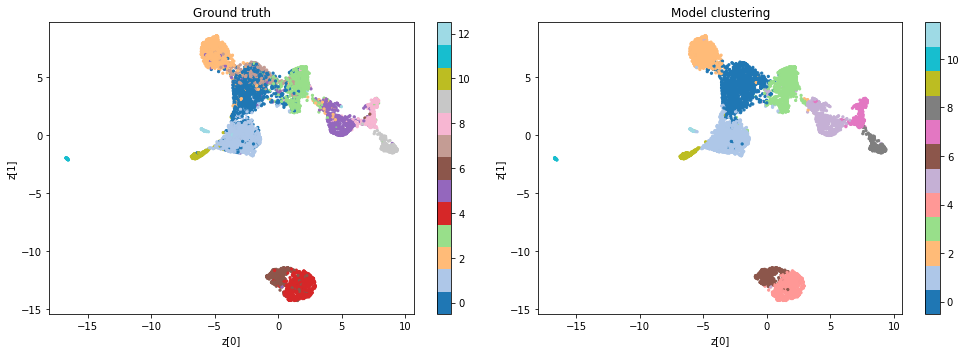

Measures of clusters similarity:

adjusted random index = 0.7222648996494563
adjusted mutual information = 0.7697887654525835
clustering accuracy = 0.8535117056856187


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [20]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [21]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

# Clustering analysis on 3k PBMC data

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 300,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,300,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1838)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          367800      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC3k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC3k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC3k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC3k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC3k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc3k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.951270, dis. loss: 0.227757


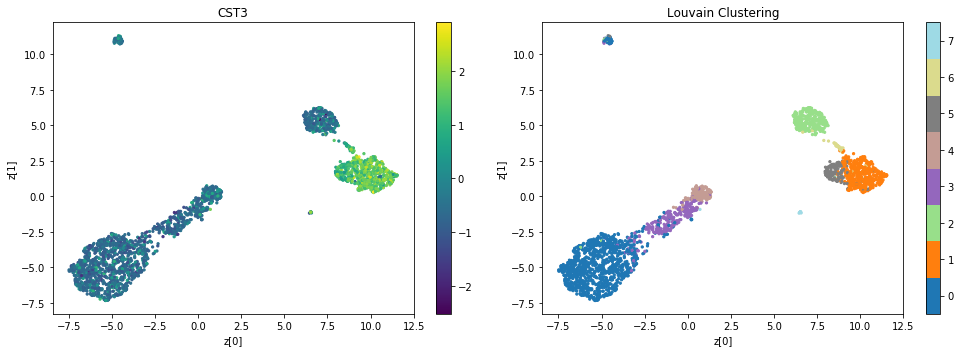

Training completed.
All networks exported in h5 format.


In [12]:
# Training...

log_dir = '../results/AAE1/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC3k/

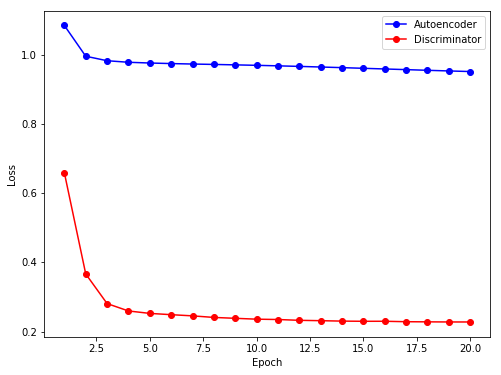

In [13]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

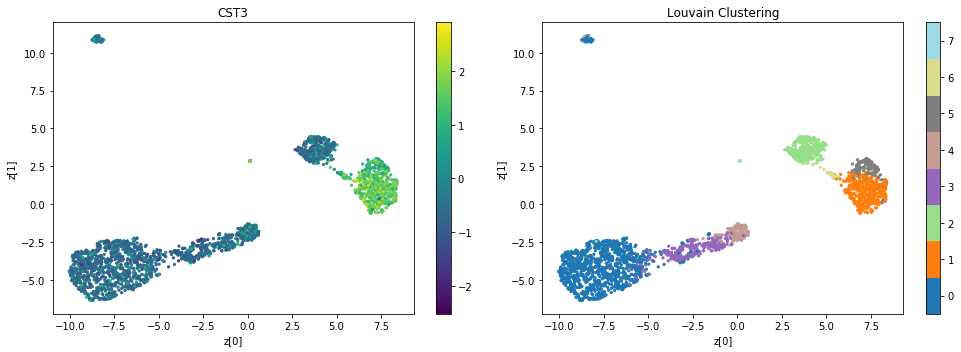

In [14]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [15:32<00:00,  5.30s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

111
111
99


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 14


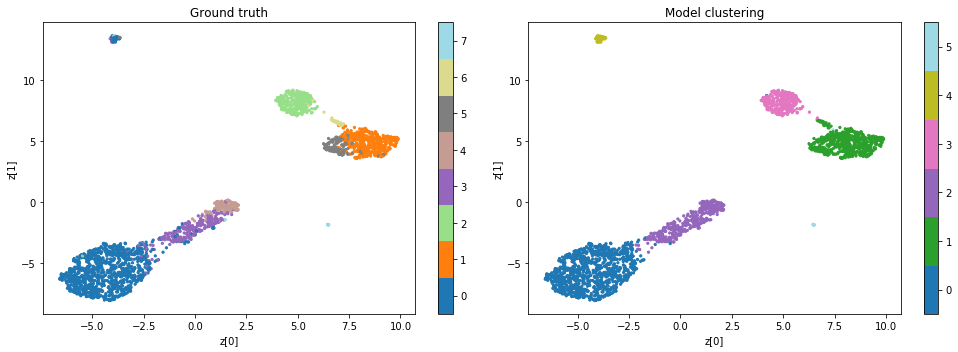

Measures of clusters similarity:

adjusted random index = 0.789900085120574
adjusted mutual information = 0.7269260766131123
clustering accuracy = 0.819560272934041


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC3k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC3k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC3k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC3k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC3k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc3k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 300,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,300,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1838)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          367800      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC3k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC3k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC3k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC3k/graphs/autoencoder.png)

### Train the model

In [14]:
# Training...

log_dir = '../results/VAE/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc3k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Dataset',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 7 steps, validate for 1 steps
Epoch 1/500
7/7 [==============================] - 4s 529ms/step - loss: 2308.9975 - val_loss: 2242.5149
Epoch 2/500
7/7 [==============================] - 0s 38ms/step - loss: 2265.7782 - val_loss: 2226.8501
Epoch 3/500
7/7 [==============================] - 0s 37ms/step - loss: 2224.8841 - val_loss: 2212.7676
Epoch 4/500
7/7 [==============================] - 0s 39ms/step - loss: 2187.4627 - val_loss: 2199.5107
Epoch 5/500
7/7 [==============================] - 0s 38ms/step - loss: 2152.2404 - val_loss: 2187.3923
Epoch 6/500
7/7 [==============================] - 0s 38ms/step - loss: 2127.5723 - val_loss: 2176.5547
Epoch 7/500
7/7 [==============================] - 0s 39ms/step - loss: 2088.4386 - val_loss: 2163.8792
Epoch 8/500
7/7 [==============================] - 0s 40ms/step - loss: 2069.3062 - val_loss: 2155.7656
Epoch 9/500
7/7 [==============================] - 0s 41ms/step - loss: 2051.9545 - val_loss: 2141.6116

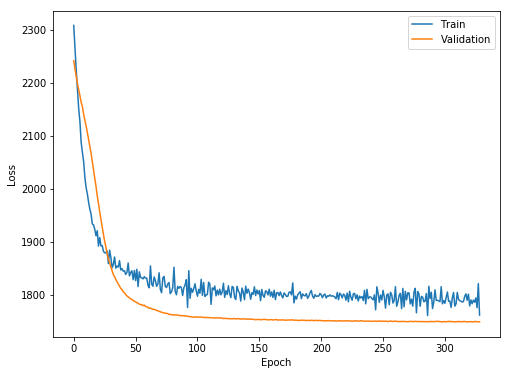

In [16]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

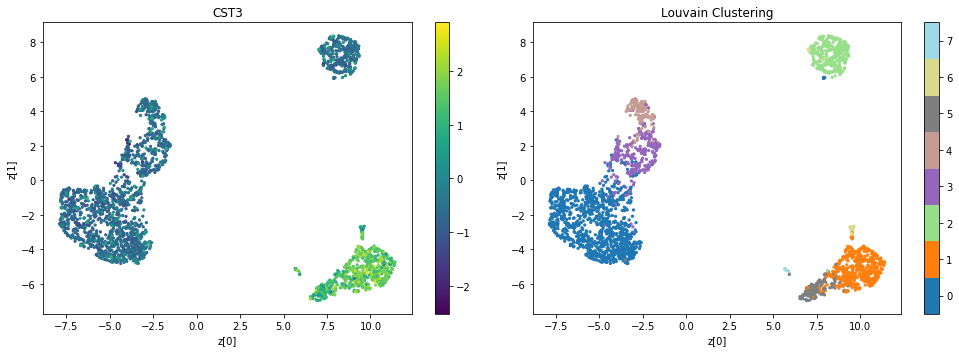

In [17]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/VAE/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [19]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [1:19:04<00:00, 26.95s/it]    


In [21]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

88
88
88


In [22]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 13


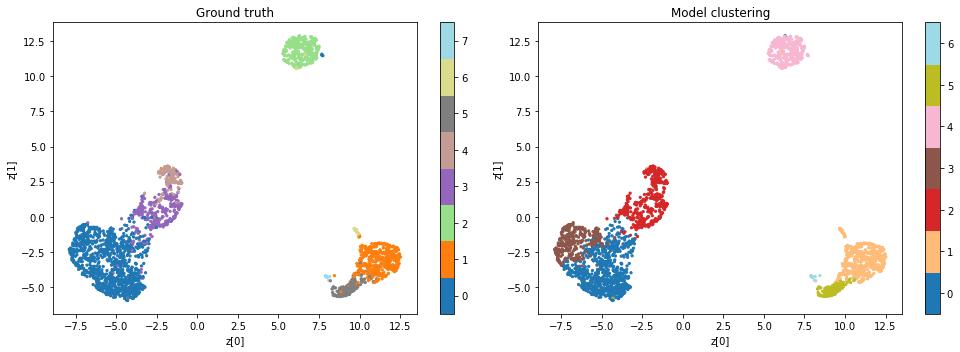

Measures of clusters similarity:

adjusted random index = 0.6484667539992132
adjusted mutual information = 0.742921251146144
clustering accuracy = 0.7524639878695982


In [23]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [24]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [25]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)